In [15]:
import numpy as np
import pandas as pd

In [16]:

import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

**test whether the system has a GPU support and fix device variable accordingly**

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Set the random seeds for deterministic results.**

In [18]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data analysis

In [19]:
train_df = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv.zip")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [20]:
# remove Null Values
train_df.dropna(inplace=True)
train_df = train_df.sample(30000, random_state = 42)
print(train_df.shape)
train_df.info()

(30000, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 8067 to 125931
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


### Draw graph which shows number of words in both questions.

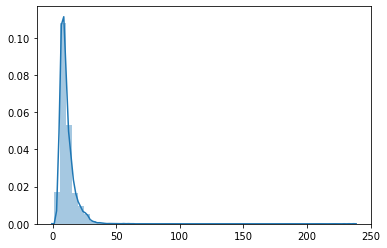

In [21]:
train_sentences_lens = train_df['question1'].apply(lambda x: len(x.split(' '))).tolist()
train_sentences_lens.extend(train_df['question2'].apply(lambda x: len(x.split(' '))).tolist())
sns.distplot(train_sentences_lens)

As we see from the graph, the number of cases where words counts greater than 40 is too small.

In [22]:
MAX_LEN = 40

### Draw pie chart which shows distribution of positive and negative examples

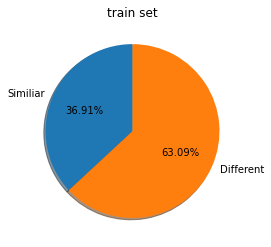

In [23]:
def pie_chart(similar_questions_num, different_questions_num, set_type):
    labels = 'Similiar', 'Different'
    sizes = [similar_questions_num, different_questions_num]

    fig1, ax1 = plt.subplots()
    ax1.set_title(set_type)
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)

    plt.show()

similar_samples_num = sum(train_df['is_duplicate'].values)
pie_chart(similar_samples_num, len(train_df['is_duplicate']) - similar_samples_num, 'train set')

The data is more or less balanced

### See most frequently asked questions

In [24]:
qids = pd.Series(list(train_df['qid1']) + list(train_df['qid2']))

print ('Unique Questions number: {}\n'.format(len(np.unique(qids))))

q_vals=qids.value_counts()[0:5]
print ('Top 5 most frequently asked questions: ')

for pair in q_vals.iteritems():
    print(train_df.loc[train_df['qid2']==pair[0]]['question1'].head(1).values + " count: " + str(pair[1]))

q_vals=q_vals.values

Unique Questions number: 55447

Top 5 most frequently asked questions: 
['How do I lose weight healthily and tone up, especially my abdominal and thighs?  count: 14']
['How can we earn money through online? count: 14']
['Orgasm, Sex: During lovemaking, how does a girl know that the boy has climaxed? count: 11']
['How can I lose 15 pounds in a month? count: 10']
['How did you learn to speak English? count: 9']


### Checking whether there are any repeated pair of questions

In [25]:
duplicate_rows = train_df[train_df.duplicated(['qid1','qid2'])]
print ("Number of duplicate questions : ", len(duplicate_rows))

Number of duplicate questions :  0


### Plot representing unique and repeated question counts

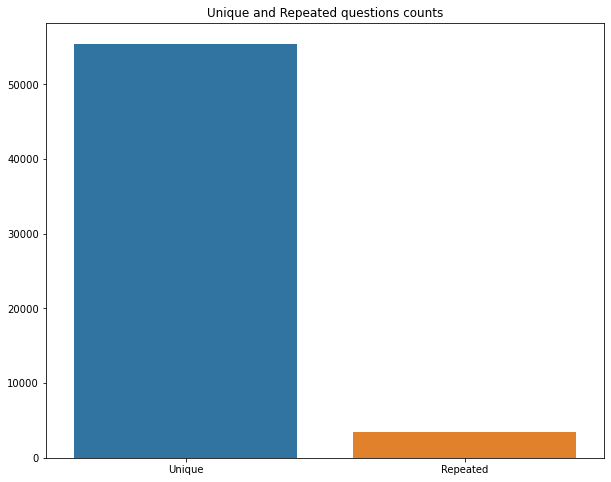

In [26]:
x = ["Unique" , "Repeated"]
y =  [len(np.unique(qids)), np.sum(qids.value_counts() > 1)]

plt.figure(figsize=(10, 8))
plt.title ("Unique and Repeated questions counts")
sns.barplot(x,y)
plt.show()

### Common words plots

In [ ]:
# Number of common unique words in question1 and question2
def common_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(q1_word_set & q2_word_set)

train_df['common_words'] = train_df.apply(common_words, axis=1)

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1]['common_words'][0:] , label = "1", color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0]['common_words'][0:] , label = "0" , color = 'blue' )

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_words', data = train_df[0:])

plt.show()

common words distributions more or less the same in both kind of question pairs

### Shared words plots

In [ ]:
# Number of common words between question1 and question2 divided by total words between both of them
def shared_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(q1_word_set & q2_word_set) / (len(q1_word_set) + len(q2_word_set))    

train_df['shared_words'] = train_df.apply(shared_words, axis=1)

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1]['shared_words'][0:] , label = "1", color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0]['shared_words'][0:] , label = "0" , color = 'green' )

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'shared_words', data = train_df[0:])

plt.show()

As we can see from the graphs, the rate of shared words is on average higher in similar question pairs

# Dataset Preparation

In [27]:
BERT_VERSION = 'bert-base-uncased'
POOLED_OUTPUT_DIM = 768 

In [28]:
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

In [29]:
# split data to train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [30]:
class BertDataSet:
    def __init__(self, first_questions, second_questions, targets, tokenizer):
        self.first_questions = first_questions
        self.second_questions = second_questions
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(first_questions)
        
    def __len__(self):
        return self.length

    def __getitem__(self, item):
        first_question = str(self.first_questions[item])
        second_question = str(self.second_questions[item])

        # removes extra white spaces from questions
        first_question = " ".join(first_question.split())
        second_question = " ".join(second_question.split())
        
        ### [CLS] question1 [SEP] questions2 [SEP] ... [PAD]
        inputs = self.tokenizer.encode_plus(
            first_question,
            second_question,
            add_special_tokens=True,
            padding='max_length',
            max_length=2 * MAX_LEN + 3, # max length of 2 questions and 3 special tokens
            truncation=True   
        )
        
        # return targets 0, when using data set in testing and targets are none
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long) if self.targets is not None else 0
        }
        

In [31]:
# creates dataset and returns dataloader of it
def get_data_loader(df, targets, batch_size, shuffle, tokenizer):
    dataset = BertDataSet(
        first_questions=df["question1"].values,
        second_questions=df["question2"].values,
        targets=targets,
        tokenizer=tokenizer
    )
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle
    )
    
    return data_loader

In [32]:
# training batch size we gonna use throughout this notebook.
BS = 128

In [33]:
# create data loaders of training and validation data.
train_data_loader = get_data_loader(
    df=train_df,
    targets=train_df["is_duplicate"].values,
    batch_size=BS,
    shuffle=True,
    tokenizer=tokenizer
)

val_data_loader = get_data_loader(
    df=val_df,
    targets=val_df["is_duplicate"].values,
    batch_size=4 * BS,
    shuffle=True,
    tokenizer=tokenizer
)

# Model

In [34]:
class BertModel(nn.Module):
    def __init__(self, bert_path):
        super(BertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooled = self.bert(ids, attention_mask=mask,token_type_ids=token_type_ids)
        
        # add dropout to prevent overfitting.
        pooled = self.dropout(pooled) 
        return self.out(pooled)

model = BertModel(BERT_VERSION).to(device)

# Training

In [35]:
# loss function is simple binary cross entropy loss
# need sigmoid to put probabilities in [0,1] interval
def loss_fn(outputs, targets):
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)

In [36]:
# computes perplexity on validation data
def calculate_perplexity(data_loader, model, device):
    model.eval()
    
    # tells Pytorch not to store values of intermediate computations for backward pass because we not gonna need gradients.
    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            total_loss += loss_fn(outputs, targets).item()
            
    model.train()

    return np.exp(total_loss / len(data_loader))

In [37]:
def train_loop(epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None):
    it = 1
    total_loss = 0
    curr_perplexity = None
    perplexity = None
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()
            
            # do forward pass, will save intermediate computations of the graph for later backprop use.
            outputs = model(ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
            # running backprop.
            loss.backward()
            
            # doing gradient descent step.
            optimizer.step()
            
            # we are logging current loss/perplexity in every 100 iteration
            if it % 100 == 0:
                
                # computing validation set perplexity in every 500 iteration.
                if it % 500 == 0:
                    curr_perplexity = calculate_perplexity(val_data_loader, model, device)
                    
                    if scheduler is not None:
                        scheduler.step()

                    # making checkpoint of best model weights.
                    if not perplexity or curr_perplexity < perplexity:
                        torch.save(model.state_dict(), 'saved_model')
                        perplexity = curr_perplexity

                print('| Iter', it, '| Avg Train Loss', total_loss / 100, '| Dev Perplexity', curr_perplexity)
                total_loss = 0

            it += 1
        

In [47]:
def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 5
    
    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    
    train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)

In [48]:
run(model, train_df, device, train_data_loader, val_data_loader)

Epoch:  1
| Iter 100 | Avg Train Loss 0.28913276717066766 | Dev Perplexity None
| Iter 200 | Avg Train Loss 0.2771375523507595 | Dev Perplexity None
Epoch:  2
| Iter 300 | Avg Train Loss 0.1938126989454031 | Dev Perplexity None
| Iter 400 | Avg Train Loss 0.18521087430417538 | Dev Perplexity None
Epoch:  3


KeyboardInterrupt: 

# Testing

In [42]:
test_df = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv")
print(test_df.shape)
test_df.head()


(2345796, 3)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [43]:
test_df = test_df.sample(1000, random_state = 42)
print(test_df.shape)
test_df.head()

(1000, 3)


,test_id,question1,question2
445115,445115,What is the source of the titles energy of the...,Can I be source of energy that create universe?
293844,293844,Is express email marketing good for a small bu...,Is email marketing good for small businesses?
2327694,2327694,"What's the difference between ""had been"" and a...","If there I determine when to use had, have, ha..."
1153389,1153389,How did your 500 opinion of Orthodox Jews chan...,How do two or more alters become a single alte...
819823,819823,"Do plants ""three pain?",What do feel pain when leaves are cut?


In [44]:
# this function returns probabilities for every test case.
def test(model, test_df, device):
    predictions = torch.empty(0).to(device, dtype=torch.float)
    
    test_dataset = BertDataSet(
        first_questions=test_df["question1"].values,
        second_questions=test_df["question2"].values,
        targets=None,
        tokenizer=tokenizer
    )
    
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=512
    )
    
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_data_loader):
            ids = batch["ids"]
            mask = batch["mask"]
            token_type_ids = batch["token_type_ids"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            predictions = torch.cat((predictions, nn.Sigmoid()(outputs)))
    
    return predictions.cpu().numpy().squeeze()

predictions = test(model, test_df, device)
len(predictions)

100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


1000

In [45]:
# write down answers in is_duplicate column.
#test_df['is_duplicate'] = predictions

In [46]:
# save results to submission.csv.
#test_df[['test_id', 'is_duplicate']].to_csv('submission.csv', index=False)

# Evaluation

In [49]:
# prints if two questions is similar and score of confidence
def eval(model, tokenizer, first_question, second_question, device):
    inputs = tokenizer.encode_plus(
        first_question,
        second_question,
        add_special_tokens=True,
    )

    ids = torch.tensor([inputs["input_ids"]], dtype=torch.long).to(device, dtype=torch.long)
    mask = torch.tensor([inputs["attention_mask"]], dtype=torch.long).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([inputs["token_type_ids"]], dtype=torch.long).to(device, dtype=torch.long)

    with torch.no_grad():
        model.eval()
        output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        prob = nn.Sigmoid()(output).item()

        print("questions [{}] and [{}] are {} with score {}".format(first_question, second_question, 'similar' if prob > 0.5 else 'not similar', prob))

In [51]:
# change questions to test model
first_question = "how can i terminate the kernel?"
second_question = "I want to kill the kernel, how can i do it?"

eval(model, tokenizer, first_question, second_question, device)

questions [how can i terminate the kernel?] and [I want to kill the kernel, how can i do it?] are similar with score 0.9681095480918884
